In [1]:
import pandas as pd
import tensorflow as tf
import random
import numpy as np
%pylab inline

/Users/teddy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/Users/teddy/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_data = pd.read_csv("data/train.csv")
y_data = pd.read_csv("data/test.csv",header=None)
print(X_data.shape)
print(y_data.shape)

(10886, 14)
(10886, 1)


In [3]:
# 2 hidden layers are enough
# parameters
n_hidden_1 = 256
n_hidden_2 = 256
n_input = X_data.shape[1]
n_output = y_data.shape[1]

X = tf.placeholder(tf.float32,[None,n_input],name='X_placeholder')
y = tf.placeholder(tf.float32,[None,n_output],name='y_placeholder')

In [4]:
# get layer
def create_network(X):
    layer1 = tf.layers.dense(X,n_hidden_1,activation='relu')
    layer2 = tf.layers.dense(layer1,n_hidden_2,activation='relu')
    out_layer = tf.layers.dense(layer2,n_output)
    
    return out_layer

In [5]:
# loss and optimizer
pred = create_network(X)

loss = tf.sqrt(tf.reduce_mean(tf.square(pred-y)),name='RMSE') #RMSE
# loss = tf.losses.mean_squared_error(out_layer,y,name='loss_mse') #MSE

optimizer = tf.train.AdagradOptimizer(learning_rate=0.05,name='optimizer').minimize(loss)

In [6]:
%%time
# train
num_case = len(X_data)
epoches = 1000
batch_size = 128
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
#     writer = tf.summary.FileWriter('./graphs/bike',sess.graph)
    
    # train
    for epoch in range(epoches):
        for i in range(0,num_case,batch_size):

            # shuffle the index
            indices = list(range(num_case))
            random.shuffle(indices)
            epoch += 1
            each_loss=0.
            idx = np.array(indices[i:min(i+batch_size, num_case)])
            batch_X = X_data.iloc[idx,:]
            batch_y = y_data.iloc[idx,:]

            _,l = sess.run([optimizer,loss],feed_dict={X:batch_X,y:batch_y})
            each_loss += l
        
        avg_loss = each_loss / int(num_case / batch_size)
        if epoch%100==0:
            print('epoch: #%s : Loss:%.4f'%(epoch,avg_loss))

    pred_value = pred.eval({X:X_data,y:y_data})
    print("The final loss is :%.4f"%avg_loss)

    # tensorboard --logdir /PATH_TO_CODE/runs/1513402825/summaries/

epoch: #100 : Loss:1.3339
epoch: #200 : Loss:0.6156
epoch: #300 : Loss:0.6266
epoch: #400 : Loss:0.5297
epoch: #500 : Loss:0.3242
epoch: #600 : Loss:0.5419
epoch: #700 : Loss:1.0378
epoch: #800 : Loss:0.2882
epoch: #900 : Loss:0.2567
epoch: #1000 : Loss:1.2343
The final loss is :0.8182
CPU times: user 10min 57s, sys: 35.7 s, total: 11min 33s
Wall time: 8min 13s


In [9]:
# validate on itself
RMSE_score = np.sqrt((pow(pred_value-np.array(y_data),2).sum())/len(y_data))
print("RMSE: %.4f"%RMSE_score)

RMSE: 65.4283


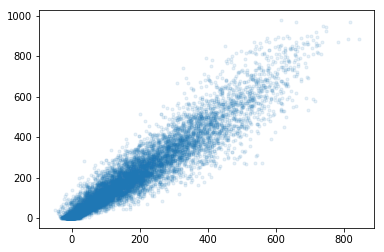

In [10]:
scatter(pred_value[:,0],y_data.values[:,0],marker='.',alpha=.1)